
# Colocalization metrics

In this example, we demonstrate the use of different metrics to assess the
colocalization of two different image channels.

Colocalization can be split into two different concepts:
1. Co-occurence: What proportion of a substance is localized to a particular
area?
2. Correlation: What is the relationship in intensity between two substances?


## Co-occurence: subcellular localization

Imagine that we are trying to determine the subcellular localization of a
protein - is it located more in the nucleus or cytoplasm compared to a
control?

We begin by segmenting the nucleus of a sample image as described in another
[example](https://scikit-image.org/docs/stable/auto_examples/applications/plot_fluorescence_nuclear_envelope.html)
and assume that whatever is not in the nucleus is in the cytoplasm.
The protein, "protein A", will be simulated as blobs and segmented.



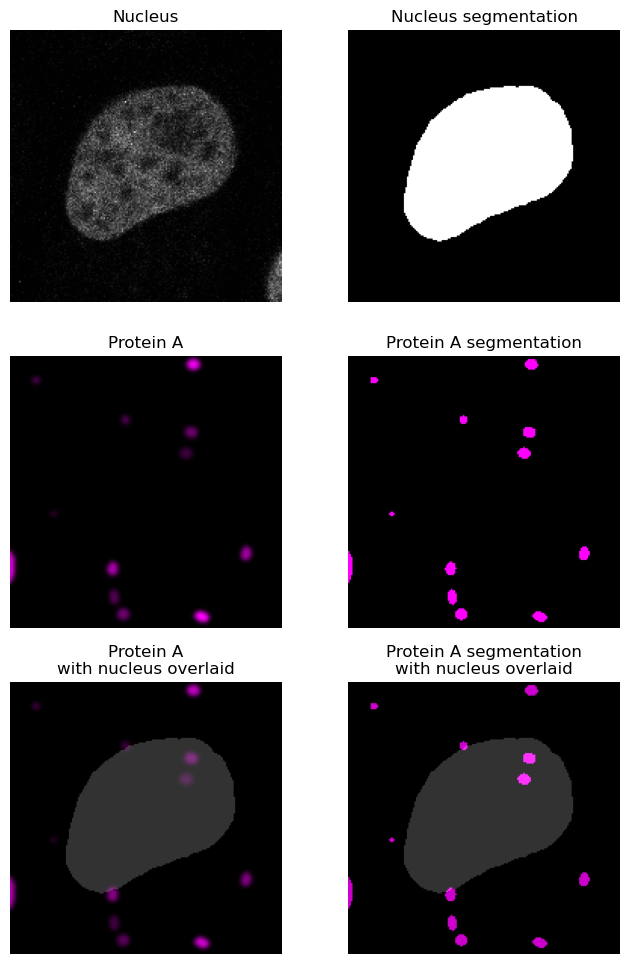

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy import ndimage as ndi
from skimage import data, filters, measure, segmentation

rng = np.random.default_rng()

# segment nucleus
nucleus = data.protein_transport()[0, 0, :, :180]
smooth = filters.gaussian(nucleus, sigma=1.5)
thresh = smooth > filters.threshold_otsu(smooth)
fill = ndi.binary_fill_holes(thresh)
nucleus_seg = segmentation.clear_border(fill)

# protein blobs of varying intensity
proteinA = np.zeros_like(nucleus, dtype="float64")
proteinA_seg = np.zeros_like(nucleus, dtype="float64")

for blob_seed in range(10):
    blobs = data.binary_blobs(180,
                              blob_size_fraction=0.5,
                              volume_fraction=(50/(180**2)),
                              rng=blob_seed)
    blobs_image = filters.gaussian(blobs, sigma=1.5) * rng.integers(50, 256)
    proteinA += blobs_image
    proteinA_seg += blobs

# plot data
fig, ax = plt.subplots(3, 2, figsize=(8, 12), sharey=True)
ax[0, 0].imshow(nucleus, cmap=plt.cm.gray)
ax[0, 0].set_title('Nucleus')

ax[0, 1].imshow(nucleus_seg, cmap=plt.cm.gray)
ax[0, 1].set_title('Nucleus segmentation')

black_magenta = LinearSegmentedColormap.from_list("", ["black", "magenta"])
ax[1, 0].imshow(proteinA, cmap=black_magenta)
ax[1, 0].set_title('Protein A')

ax[1, 1].imshow(proteinA_seg, cmap=black_magenta)
ax[1, 1].set_title('Protein A segmentation')

ax[2, 0].imshow(proteinA, cmap=black_magenta)
ax[2, 0].imshow(nucleus_seg, cmap=plt.cm.gray, alpha=0.2)
ax[2, 0].set_title('Protein A\nwith nucleus overlaid')

ax[2, 1].imshow(proteinA_seg, cmap=black_magenta)
ax[2, 1].imshow(nucleus_seg, cmap=plt.cm.gray, alpha=0.2)
ax[2, 1].set_title('Protein A segmentation\nwith nucleus overlaid')

for a in ax.ravel():
    a.set_axis_off()

## Intersection coefficient

After segmenting both the nucleus and the protein of interest, we can
determine what fraction of the protein A segmentation overlaps with the
nucleus segmentation.



In [2]:
measure.intersection_coeff(proteinA_seg, nucleus_seg)

0.22

## Manders' Colocalization Coefficient (MCC)

The overlap coefficient assumes that the area of protein segmentation
corresponds to the concentration of that protein - with larger areas
indicating more protein. As the resolution of images are usually too small to
make out individual proteins, they can clump together within one pixel,
making the intensity of that pixel brighter. So, to better capture the
protein concentration, we may choose to determine what proportion of the
*intensity* of the protein channel is inside the nucleus. This metric is
known as Manders' Colocalization Coefficient.

In this image, while there are a lot of protein A spots within the nucleus
they are dim compared to some of the spots outside the nucleus, so the MCC is
much lower than the overlap coefficient.



In [3]:
measure.manders_coloc_coeff(proteinA, nucleus_seg)

0.1348412067639367

After choosing a co-occurence metric, we can apply the same process to
control images. If no control images are available, the Costes method could
be used to compare the MCC value of the original image with that of the
randomly scrambled image. Information about this method is given in [1]_.

.. [1] J. S. Aaron, A. B. Taylor and T.-L. Chew, Image co-localization –
       co-occurrence versus correlation. J Cell Sci 1 February 2018
       131 (3): jcs211847. doi: https://doi.org/10.1242/jcs.211847



## Correlation: association of two proteins

Now, imagine that we want to know how closely related two proteins are.

First, we will generate protein B and plot intensities of the two proteins in
every pixel to see the relationship between them.



Text(0, 0.5, 'Protein B intensity')

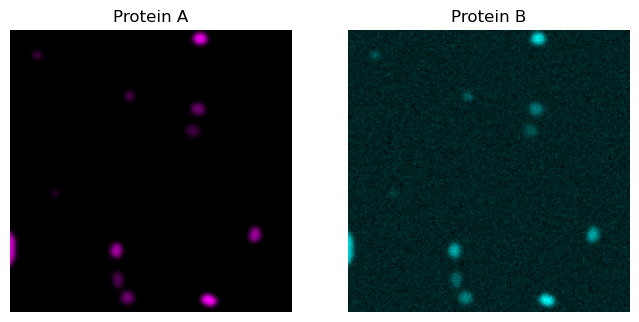

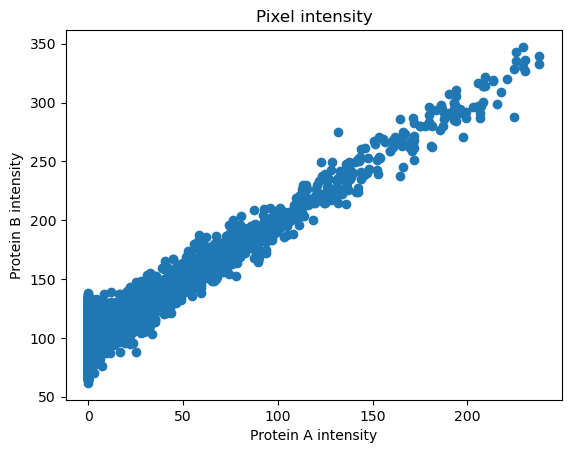

In [4]:
# generating protein B data that is correlated to protein A for demo
proteinB = proteinA + rng.normal(loc=100, scale=10, size=proteinA.shape)

# plot images
fig, ax = plt.subplots(1, 2, figsize=(8, 8), sharey=True)

ax[0].imshow(proteinA, cmap=black_magenta)
ax[0].set_title('Protein A')

black_cyan = LinearSegmentedColormap.from_list("", ["black", "cyan"])
ax[1].imshow(proteinB, cmap=black_cyan)
ax[1].set_title('Protein B')

for a in ax.ravel():
    a.set_axis_off()

# plot pixel intensity scatter
plt.figure()
plt.scatter(proteinA, proteinB)
plt.title('Pixel intensity')
plt.xlabel('Protein A intensity')
plt.ylabel('Protein B intensity')

The intensities look linearly correlated so Pearson's Correlation Coefficient
would give us a good measure of how strong the association is.



In [5]:
pcc, pval = measure.pearson_corr_coeff(proteinA, proteinB)
print(f"PCC: {pcc:0.3g}, p-val: {pval:0.3g}")

PCC: 0.826, p-val: 0


Sometimes the intensities are correlated but not in a linear way. A rank-based
correlation coefficient like [Spearman's](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html)
might give a more accurate measure of the non-linear relationship in that
case.



In [6]:
plt.show()